In [1]:
%matplotlib inline
%config Completer.use_jedi=False

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from scipy import ndimage
from skimage.transform import resize


# Local imports
import adjust_path  # Before doing any local imports
from icc.data_loader import DataLoader
from icc.models.gangsta_net import GangstaNet
from icc.models.double_down import DoubleDown

Appending "/code/notebooks/.." to path


In [2]:
X, y = DataLoader.load_train()
X['inc_angle_missing'] = X.inc_angle.map(pd.isnull)
X.inc_angle.fillna(value=0, inplace=True)
xTrain, xTest, yTrain, yTest = train_test_split(X.copy(), y.copy(), test_size=0.2)

In [4]:
clf = DoubleDown(batch_size=20, n_epoch=30, lr=0.0001, weight_decay=0.0)

clf.fit(xTrain, yTrain, xTest=xTest.copy(), yTest=yTest.copy())
pred = clf.predict_proba(xTest)[:, 1]

log_loss(yTest.values, pred)

DoubleDown: NOTE, this uses pseudo image creation, so training loss is cray-cray. ;)
DoubleDown: Epoch: 1, Train loss: 0.7542 - Test loss: 0.6901
DoubleDown: Epoch: 2, Train loss: 0.6924 - Test loss: 0.6977
DoubleDown: Epoch: 3, Train loss: 0.7034 - Test loss: 0.6816
DoubleDown: Epoch: 4, Train loss: 0.6878 - Test loss: 0.5856
DoubleDown: Epoch: 5, Train loss: 0.3842 - Test loss: 0.4741
DoubleDown: Epoch: 6, Train loss: 0.4169 - Test loss: 0.4515
DoubleDown: Epoch: 7, Train loss: 0.3614 - Test loss: 0.3195
DoubleDown: Epoch: 8, Train loss: 0.1997 - Test loss: 0.2898
DoubleDown: Epoch: 9, Train loss: 0.2633 - Test loss: 0.3041
DoubleDown: Epoch: 10, Train loss: 0.2518 - Test loss: 0.2832
DoubleDown: Epoch: 11, Train loss: 0.3067 - Test loss: 0.2500
DoubleDown: Epoch: 12, Train loss: 0.4134 - Test loss: 0.2434
DoubleDown: Epoch: 13, Train loss: 0.2857 - Test loss: 0.2256
DoubleDown: Epoch: 14, Train loss: 0.1526 - Test loss: 0.2322
DoubleDown: Epoch: 15, Train loss: 0.0655 - Test loss: 0

0.37528936264770468

In [5]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf = StackingClassifier(classifiers=[DoubleDown(batch_size=20, n_epoch=15, lr=0.0001, weight_decay=0.0)], 
                         meta_classifier=LogisticRegression(), 
                         use_probas=True)

scores = cross_val_score(clf, X, y, scoring='neg_log_loss', cv=2)
print('Mean: {}, STD: {}'.format(scores.mean(), scores.std()))

Testing data not passed to fit(), will not output testing loss during training.
DoubleDown: NOTE, this uses pseudo image creation, so training loss is cray-cray. ;)
DoubleDown: Epoch: 1, Train loss: 0.6911 
DoubleDown: Epoch: 2, Train loss: 0.7122 
DoubleDown: Epoch: 3, Train loss: 0.6930 
DoubleDown: Epoch: 4, Train loss: 0.6892 
DoubleDown: Epoch: 5, Train loss: 0.6746 
DoubleDown: Epoch: 6, Train loss: 0.6572 
DoubleDown: Epoch: 7, Train loss: 0.4133 
DoubleDown: Epoch: 8, Train loss: 0.7960 
DoubleDown: Epoch: 9, Train loss: 0.5704 
DoubleDown: Epoch: 10, Train loss: 0.4562 
DoubleDown: Epoch: 11, Train loss: 0.4362 
DoubleDown: Epoch: 12, Train loss: 0.4326 
DoubleDown: Epoch: 13, Train loss: 0.3535 
DoubleDown: Epoch: 14, Train loss: 0.4012 
DoubleDown: Epoch: 15, Train loss: 0.2232 
Testing data not passed to fit(), will not output testing loss during training.
DoubleDown: NOTE, this uses pseudo image creation, so training loss is cray-cray. ;)
DoubleDown: Epoch: 1, Train loss: 

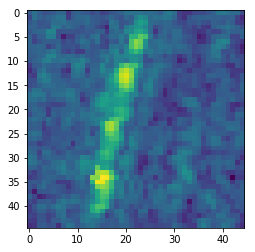

In [15]:
from skimage.transform import resize

pic = imgs[0][0]

pic = pic[15:60, 15:60]

plt.imshow(pic)

In [138]:
imgs = np.array([
    ImageTransformer.transform(
        np.dstack([img1.reshape(75, 75),
                   img2.reshape(75, 75)
                  ])
    )
    for (img1, img2) in X.loc[0:4, ['band_1', 'band_2']].values
]).swapaxes(-1, -2).swapaxes(-2, -3)
imgs.shape

(5, 10, 75, 75)

In [140]:
imgs.shape

(5, 10, 75, 75)

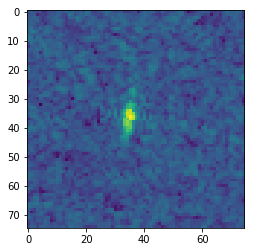

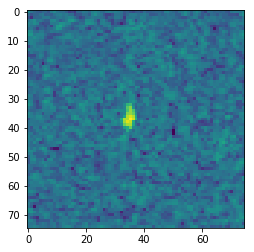

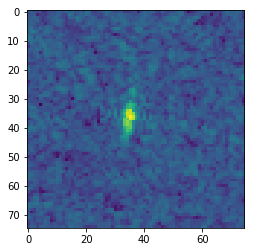

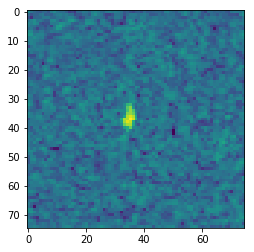

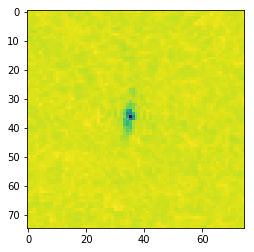

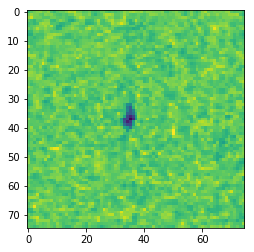

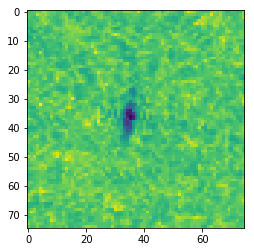

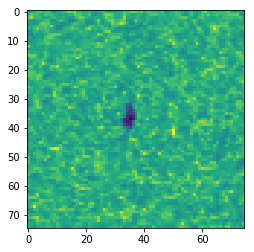

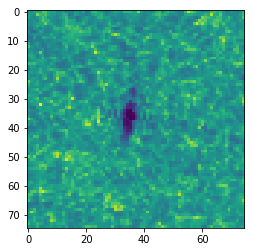

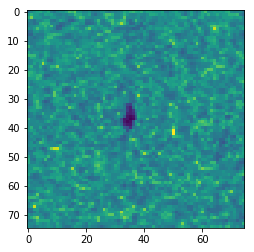

In [142]:
for img in imgs:
    for i in range(img.shape[0]):
        plt.imshow(img[i, :, :])
        plt.show()
    break

In [4]:
imgs = clf._preprocess(xTrain)
imgs.shape

(1283, 14, 75, 75)

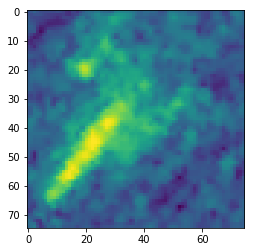

In [5]:
plt.imshow(imgs[1, 0, :, :].reshape(75, 75))

In [7]:
# network layer trials
img_size = 75
in_channels = imgs.shape[1]
flattened_size = 14112

input1_layer1_conv2d = nn.Conv2d(in_channels=in_channels, out_channels=32,  kernel_size=5, padding=3)
input1_layer2_conv2d = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=3)
input1_layer3_conv2d = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=3)
input1_layer4_conv2d = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=3)

fc1 = nn.Linear(in_features=flattened_size, out_features=512)
pool_big = nn.MaxPool2d(kernel_size=3, stride=2, )
pool = nn.MaxPool2d(kernel_size=2, stride=2, )


pics = torch.FloatTensor(imgs[:2, :, :, :])
pics = Variable(pics)

pics = (input1_layer1_conv2d(pics))
pics = pool(pics)

pics = (input1_layer2_conv2d(pics))
pics = pool(pics)

pics = (input1_layer3_conv2d(pics))
pics = pool(pics)

pics = (input1_layer4_conv2d(pics))
pics = pool(pics)

print(pics.size())
print(np.prod(pics.size()[1:]))

fc1(pics.view(-1, flattened_size))

torch.Size([2, 32, 6, 6])
1152


RuntimeError: invalid argument 2: size '[-1 x 14112]' is invalid for input of with 2304 elements at /pytorch/torch/lib/TH/THStorage.c:37

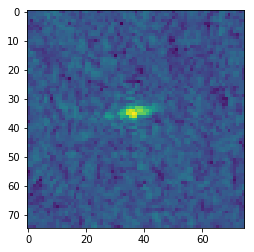

In [74]:
plt.imshow(np.swapaxes(img, 0, -1)[0, :, :])